In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'WD_Kernel': WeightedDegree_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel
    
}

In [3]:
# setting

cv = 5
test_size = 0.2
random_state = 24
embedding = 'label'
eva_on_ave_flag = True # true label is the sample mean instead of individual samples, since the prediction is the posterior mean
eva_metric = mean_squared_error # mean square error returns a more stable optimal hyparameter choice than r2 score

kernel_list = ['Spectrum_Kernel', 
               #'Sum_Spectrum_Kernel', 
               'WD_Kernel']
alpha_list = [0.1, 1, 2, 3, 5, 10]
l_lists = [[3], [6]]
b_list = [0.33, 0.6, 0.8]

weight_flag = False
padding_flag = False
gap_flag = False

In [4]:
Path = '../../data/firstRound_4h_normTrue_formatSeq.csv'

df = pd.read_csv(Path)
df.head(20)

Unnamed: 0         Name        Group                   RBS    RBS6  Rep1  \
0            0   RBS_1by1_0    reference  TTTAAGAAGGAGATATACAT  AGGAGA   NaN   
1            1   RBS_1by1_1  bps_noncore  CTTAAGAAGGAGATATACAT  AGGAGA   NaN   
2            2   RBS_1by1_2  bps_noncore  GTTAAGAAGGAGATATACAT  AGGAGA   NaN   
3            3   RBS_1by1_3  bps_noncore  ATTAAGAAGGAGATATACAT  AGGAGA   NaN   
4            4   RBS_1by1_4  bps_noncore  TCTAAGAAGGAGATATACAT  AGGAGA   NaN   
5            5   RBS_1by1_5  bps_noncore  TGTAAGAAGGAGATATACAT  AGGAGA   NaN   
6            6   RBS_1by1_6  bps_noncore  TATAAGAAGGAGATATACAT  AGGAGA   NaN   
7            8   RBS_1by1_8  bps_noncore  TTGAAGAAGGAGATATACAT  AGGAGA   NaN   
8            9   RBS_1by1_9  bps_noncore  TTAAAGAAGGAGATATACAT  AGGAGA   NaN   
9           10  RBS_1by1_10  bps_noncore  TTTCAGAAGGAGATATACAT  AGGAGA   NaN   
10          11  RBS_1by1_11  bps_noncore  TTTGAGAAGGAGATATACAT  AGGAGA   NaN   
11          12  RBS_1by1_12  bps_noncore  TTTTAGAAGGAGATATACAT  AGGAGA   NaN   
12          13  RBS_1by1_13  bps_noncore  TTTACGAAGGAGATATACAT  AGGAGA   NaN   
13          14  RBS_1by1_14  bps_noncore  TTTAGGAAGGAGATATACAT  AGGAGA   NaN   
14          15  RBS_1by1_15  bps_noncore  TTTATGAAGGAGATATACAT  AGGAGA   NaN   
15          16  RBS_1by1_16  bps_noncore  TTTAACAAGGAGATATACAT  AGGAGA   NaN   
16          17  RBS_1by1_17  bps_noncore  TTTAAAAAGGAGATATACAT  AGGAGA   NaN   
17          18  RBS_1by1_18  bps_noncore  TTTAATAAGGAGATATACAT  AGGAGA   NaN   
18          19  RBS_1by1_19  bps_noncore  TTTAAGCAGGAGATATACAT  AGGAGA   NaN   
19          20  RBS_1by1_20  bps_noncore  TTTAAGGAGGAGATATACAT  AGGAGA   NaN   

        Rep2  Rep3      Rep4      Rep5   AVERAGE       STD  
0   2.783529   NaN  3.260245  3.225496  3.089757  0.265769  
1   1.678119   NaN  1.589655  2.374458  1.880744  0.429851  
2   0.670263   NaN  0.091788  0.295688  0.352580  0.293404  
3   1.948917   NaN  1.299476  1.653915  1.634102  0.325173  
4   2.201733   NaN  1.786760  1.687616  1.892036  0.272748  
5   0.055417   NaN -0.188262  0.006650 -0.042065  0.128937  
6   1.259399   NaN  0.539809  1.048676  0.949295  0.369946  
7   1.689308   NaN  1.861887  1.713073  1.754756  0.093536  
8   0.521988   NaN  0.061684  0.082107  0.221926  0.260062  
9   0.858082   NaN  1.263810  1.032268  1.051387  0.203539  
10  2.110693   NaN  1.591386  1.776395  1.826158  0.263206  
11  1.478876   NaN  1.166064  1.093599  1.246180  0.204752  
12  1.419337   NaN  1.473330  1.202206  1.364958  0.143509  
13  1.377429   NaN  1.221965  0.862560  1.153985  0.264080  
14  0.232285   NaN  0.109480 -0.073387  0.089459  0.153816  
15  0.748619   NaN  0.325827  0.571472  0.548639  0.212319  
16  0.336968   NaN  0.132144  0.218787  0.229300  0.102816  
17  0.615321   NaN  0.334924  0.335069  0.428438  0.161846  
18  0.053024   NaN -0.073765  0.038435  0.005898  0.069375  
19  1.538647   NaN  0.666365  0.106356  0.770456  0.721797

## Run over different train test splitting

Train:  0.9128981292225194
Test:  -1.0268691301156414


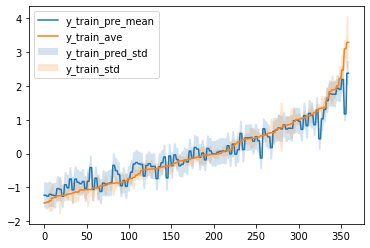

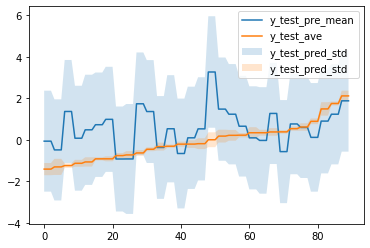

Train:  0.9106296522980732
Test:  -1.894744869827667


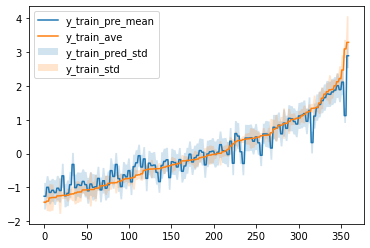

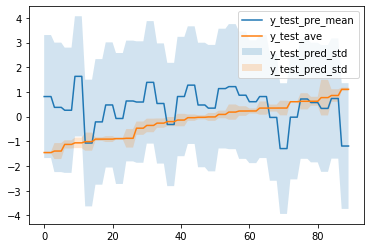

Train:  0.8886344811804882
Test:  -0.17653244287013892


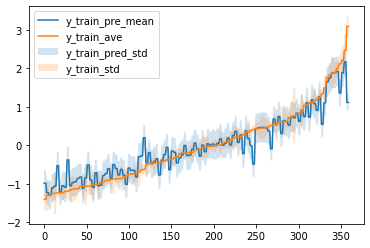

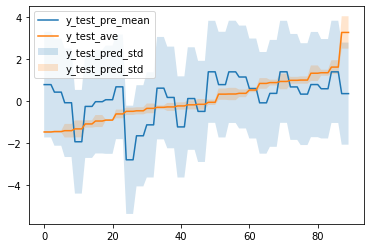

Train:  0.8960852866448992
Test:  -0.7774791851474196


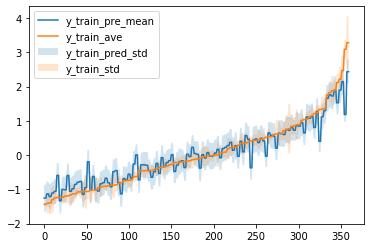

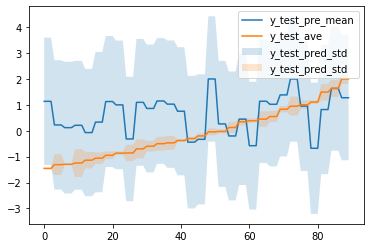

Train:  0.8945389246134178
Test:  -0.23578697548315142


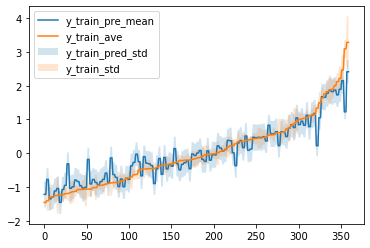

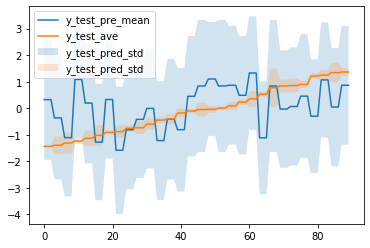

In [5]:
for i in range(5):
    regression(df, random_state=i, test_size=0.2, kernel_name='WD_Kernel',alpha=0.5, embedding='label',
                   eva_metric=r2_score, eva_on_ave_flag=True, l_list=[3], b=0.33, 
                   weight_flag=False, padding_flag=False, gap_flag=False)

## Drop sequences with small averages

In [6]:
#df = df[df['Group'] != 'bps'].reset_index()
df_sorted = df.sort_values(by = 'AVERAGE', ascending = False).reset_index()
df_positive_ave = df_sorted[df_sorted['AVERAGE'] > 0]

Train:  0.9346783648258056
Test:  -0.625417679220633


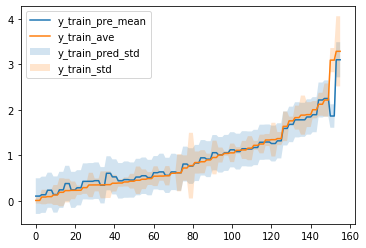

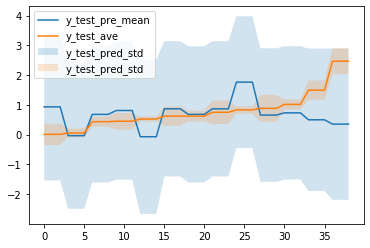

Train:  0.9334132245817653
Test:  -1.2977722354362315


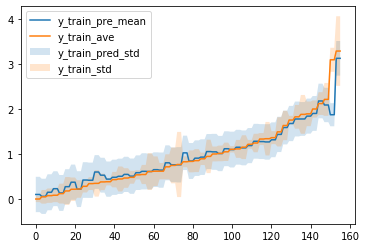

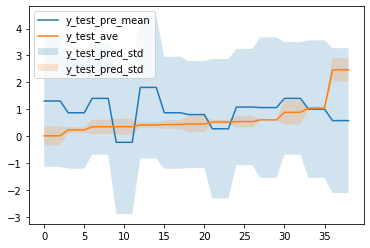

Train:  0.9879170604921965
Test:  -1.239494669102371


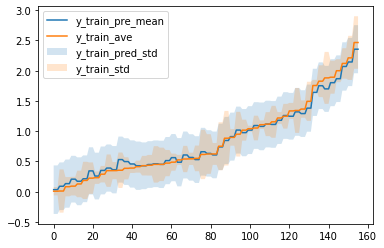

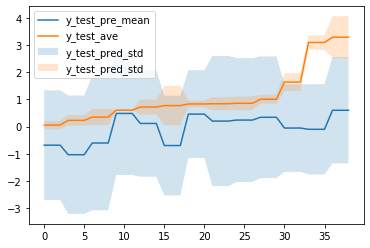

Train:  0.9331262600426431
Test:  -0.546755143026264


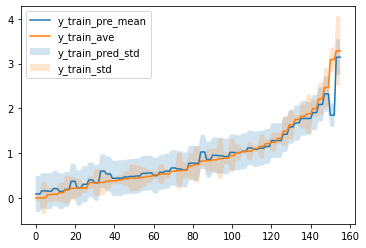

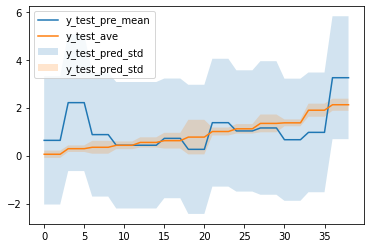

Train:  0.9278112821729685
Test:  -0.8072719236144756


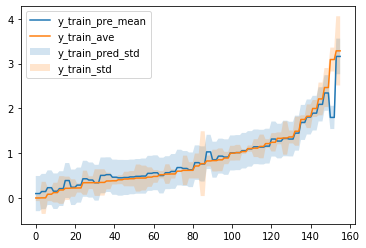

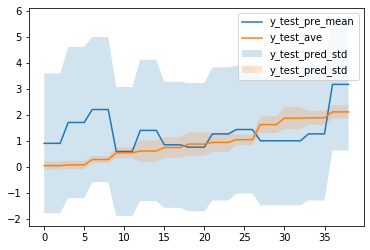

In [7]:
for i in range(5):
    regression(df_positive_ave, random_state=i, test_size=0.2, kernel_name='WD_Kernel',alpha=0.5, embedding='label',
                   eva_metric=r2_score, eva_on_ave_flag=True, l_list=[3], b=0.33, 
                   weight_flag=False, padding_flag=False, gap_flag=False)

## Replicates sequences with high averages

In [8]:
df_rep_pos = df_positive_ave.append(df_positive_ave).reset_index()

Train:  0.9629022152992751
Test:  -6.4047533991314936


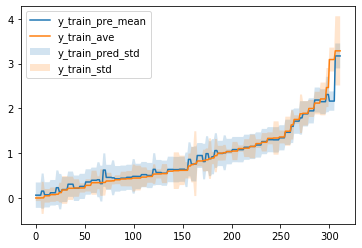

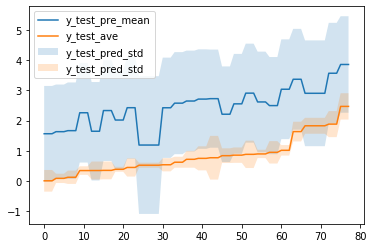

Train:  0.9633960513165865
Test:  -0.03451110533837953


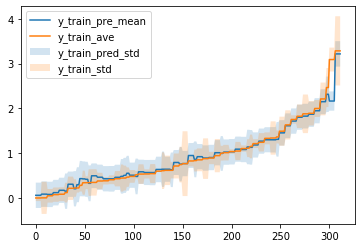

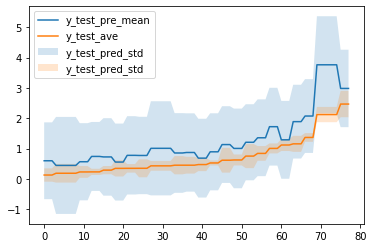

Train:  0.9605609196421521
Test:  -3.7496145219391206


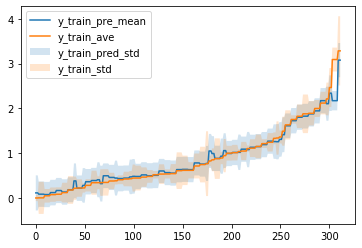

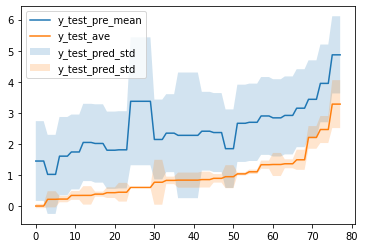

Train:  0.9590088624000942
Test:  0.7111631475312078


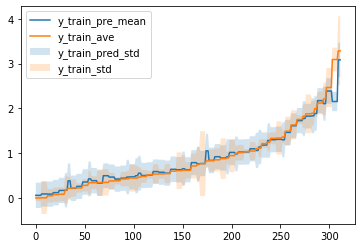

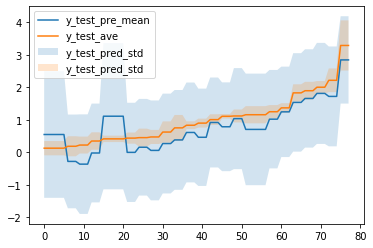

Train:  0.9548609382169999
Test:  -0.21382735918603935


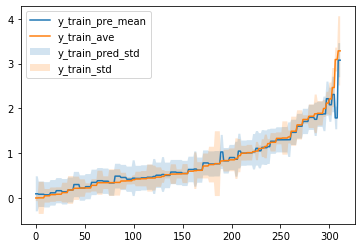

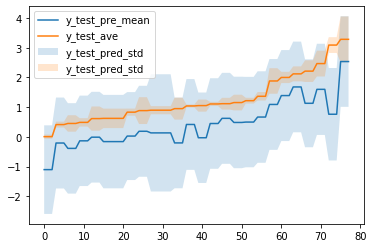

In [9]:
for i in range(5):
    regression(df_rep_pos, random_state=i, test_size=0.2, kernel_name='WD_Kernel',alpha=0.5, embedding='label',
                   eva_metric=r2_score, eva_on_ave_flag=True, l_list=[3], b=0.33, 
                   weight_flag=False, padding_flag=False, gap_flag=False)